<img src="https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/logoFIUBA.jpg" width="500" align="center">


# Series Temporales
### Sergio Hinojosa


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import curve_fit

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA

## Dataset

Ventas al mercado interno de Producción Nacional de Vino en miles de hectolitros. Base 1994

In [2]:
dataset = pd.read_csv('dataset/ventas-al-mercado-interno-vitivinicola-base-1994-valores-mensuales.csv')
dataset.head()

,indice_tiempo,vino
0,1994-01-01,1055.0
1,1994-02-01,1029.0
2,1994-03-01,1214.0
3,1994-04-01,1193.0
4,1994-05-01,1235.0


Cantidad de muestras y tipo de datos:

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   indice_tiempo  362 non-null    object 
 1   vino           322 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


Convierto el tipo de dato del indice de tiempo al tipo datetime.

In [4]:
dataset["indice_tiempo"]=pd.to_datetime(dataset["indice_tiempo"], format='%Y-%m-%d')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   indice_tiempo  362 non-null    datetime64[ns]
 1   vino           322 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


### Valores nulos

In [5]:
nan_rows = dataset[dataset.isnull().any(axis=1)]
print(len(nan_rows))

40


In [6]:
print(nan_rows)

    indice_tiempo  vino
322    2020-11-01   NaN
323    2020-12-01   NaN
324    2021-01-01   NaN
325    2021-02-01   NaN
326    2021-03-01   NaN
327    2021-04-01   NaN
328    2021-05-01   NaN
329    2021-06-01   NaN
330    2021-07-01   NaN
331    2021-08-01   NaN
332    2021-09-01   NaN
333    2021-10-01   NaN
334    2021-11-01   NaN
335    2021-12-01   NaN
336    2022-01-01   NaN
337    2022-02-01   NaN
338    2022-03-01   NaN
339    2022-04-01   NaN
340    2022-05-01   NaN
341    2022-06-01   NaN
342    2022-07-01   NaN
343    2022-08-01   NaN
344    2022-09-01   NaN
345    2022-10-01   NaN
346    2022-11-01   NaN
347    2022-12-01   NaN
348    2023-01-01   NaN
349    2023-02-01   NaN
350    2023-03-01   NaN
351    2023-04-01   NaN
352    2023-05-01   NaN
353    2023-06-01   NaN
354    2023-07-01   NaN
355    2023-08-01   NaN
356    2023-09-01   NaN
357    2023-10-01   NaN
358    2023-11-01   NaN
359    2023-12-01   NaN
360    2024-01-01   NaN
361    2024-02-01   NaN


Los valores nulos corresponden a los ultimos 40 meses. Elimino estos indices de tiempo:

In [7]:
dataset = dataset[dataset["indice_tiempo"] < '2020-11-01']

nan_rows = dataset[dataset.isnull().any(axis=1)]
print(len(nan_rows))

0


Ya no hay valores faltantes.

### Gráfica del dataset

Text(0, 0.5, 'Ventas (hectolitros)')

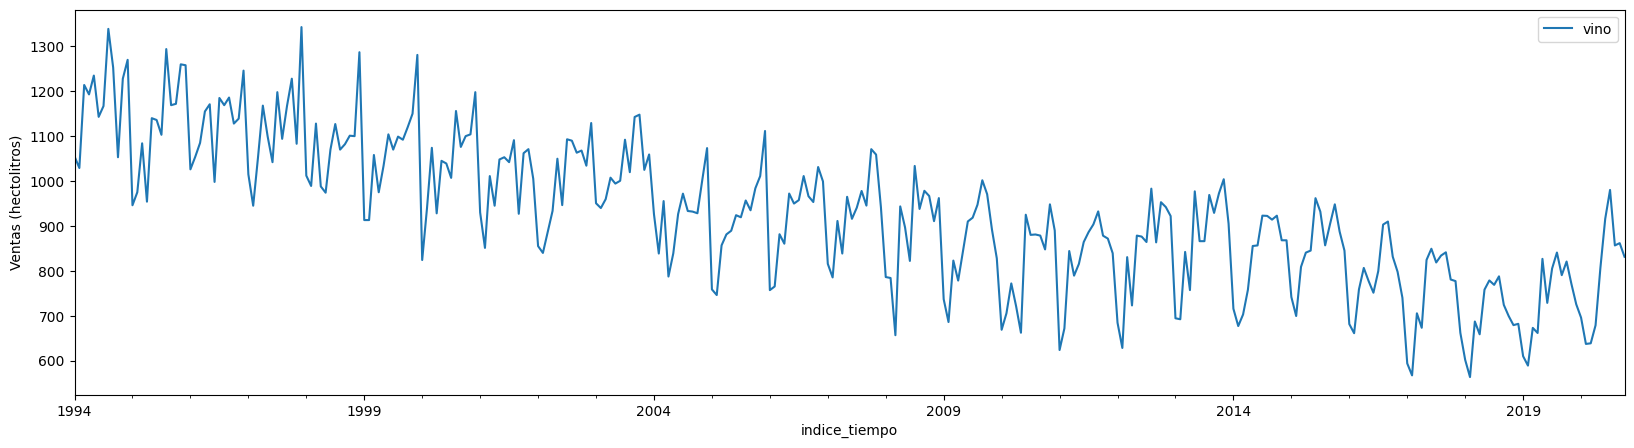

In [8]:
dataset.plot(x = 'indice_tiempo', y = 'vino', figsize=(20, 5))
plt.ylabel("Ventas (hectolitros)")

In [9]:
dataset.describe()

,indice_tiempo,vino
count,322,322.000000
mean,2007-05-17 09:14:32.049689344,927.463452
min,1994-01-01 00:00:00,563.160000
25%,2000-09-08 12:00:00,823.027603
50%,2007-05-16 12:00:00,928.091000
75%,2014-01-24 06:00:00,1044.250000
max,2020-10-01 00:00:00,1343.000000
std,NaN,160.407668


In [10]:
fechas_description = dataset.agg(min=('indice_tiempo', np.min), max=('indice_tiempo', np.max))
fechas_description

,indice_tiempo
min,1994-01-01
max,2020-10-01


El intervalo de tiempo medido es de el 1/1/1994 al 1/10/2020, una medición por mes.

Se observa un comportamiento ciclico con período de un año, se hace más evidente en los últimos años.

Se puede observar también una tendencia decreciente, a primera vista lineal.

### Observación de 5 años

Para observar mejor los ciclos, se toma de muestra 5 años:

<Axes: xlabel='indice_tiempo'>

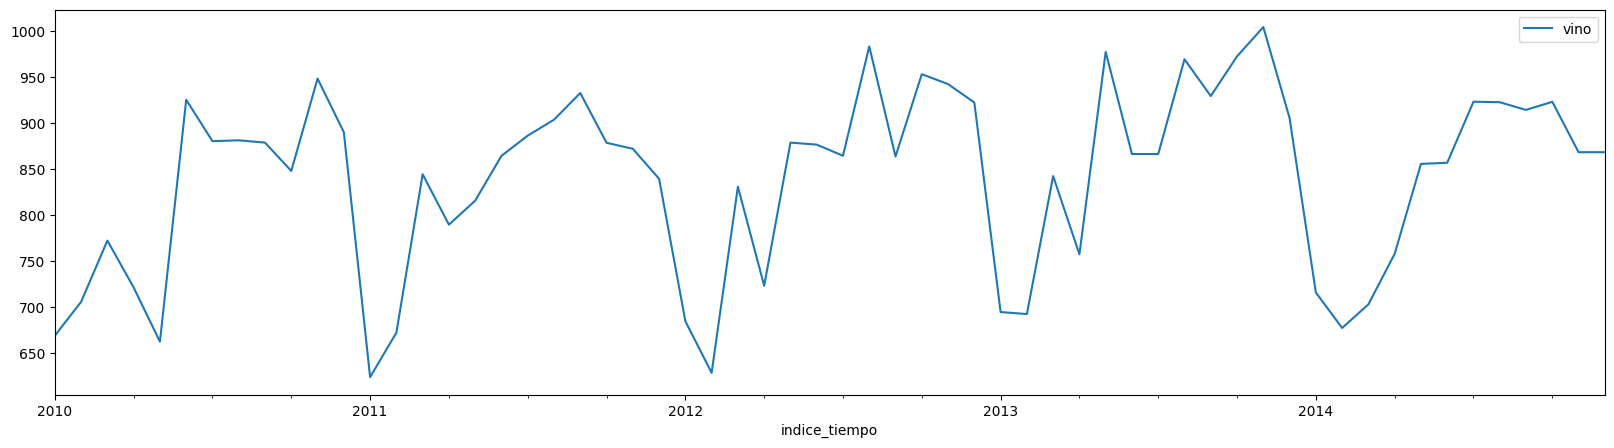

In [11]:
dataset_year = dataset[dataset["indice_tiempo"] < '2015-1-1']
dataset_year = dataset_year[dataset_year["indice_tiempo"] > '2009-12-31']

dataset_year.plot(x = 'indice_tiempo', y = 'vino', figsize=(20, 5))

Se puede apreciar que el comportamiento ciclico se da anualmente, siendo los meses de menos ventas en los 2 primeros meses y los máximos a finales de año.  

Un ciclo cuenta con 12 muestras, extrayendo uno de ejemplo se ve como el siguiente gráfico:  

<Axes: xlabel='indice_tiempo'>

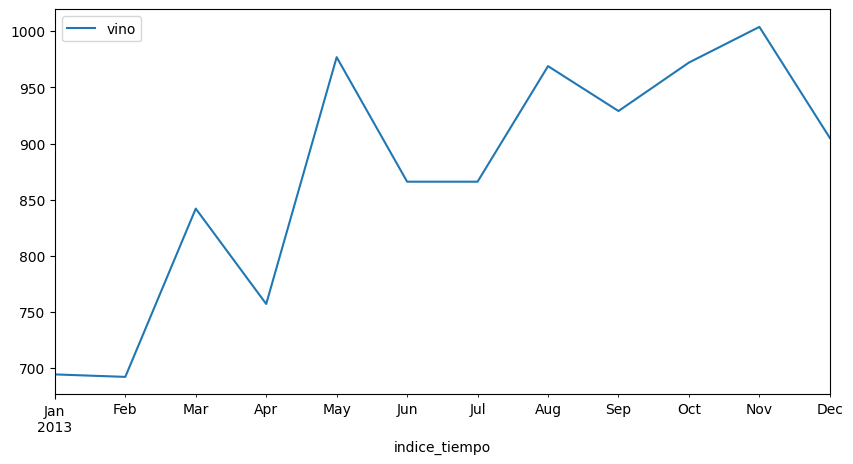

In [12]:
dataset_year = dataset[dataset["indice_tiempo"] < '2014-1-1']
dataset_year = dataset_year[dataset_year["indice_tiempo"] > '2012-12-31']

dataset_year.plot(x = 'indice_tiempo', y = 'vino', figsize=(10, 5))

### Descomposición de la serie usando el modelo aditivo de 4 componentes

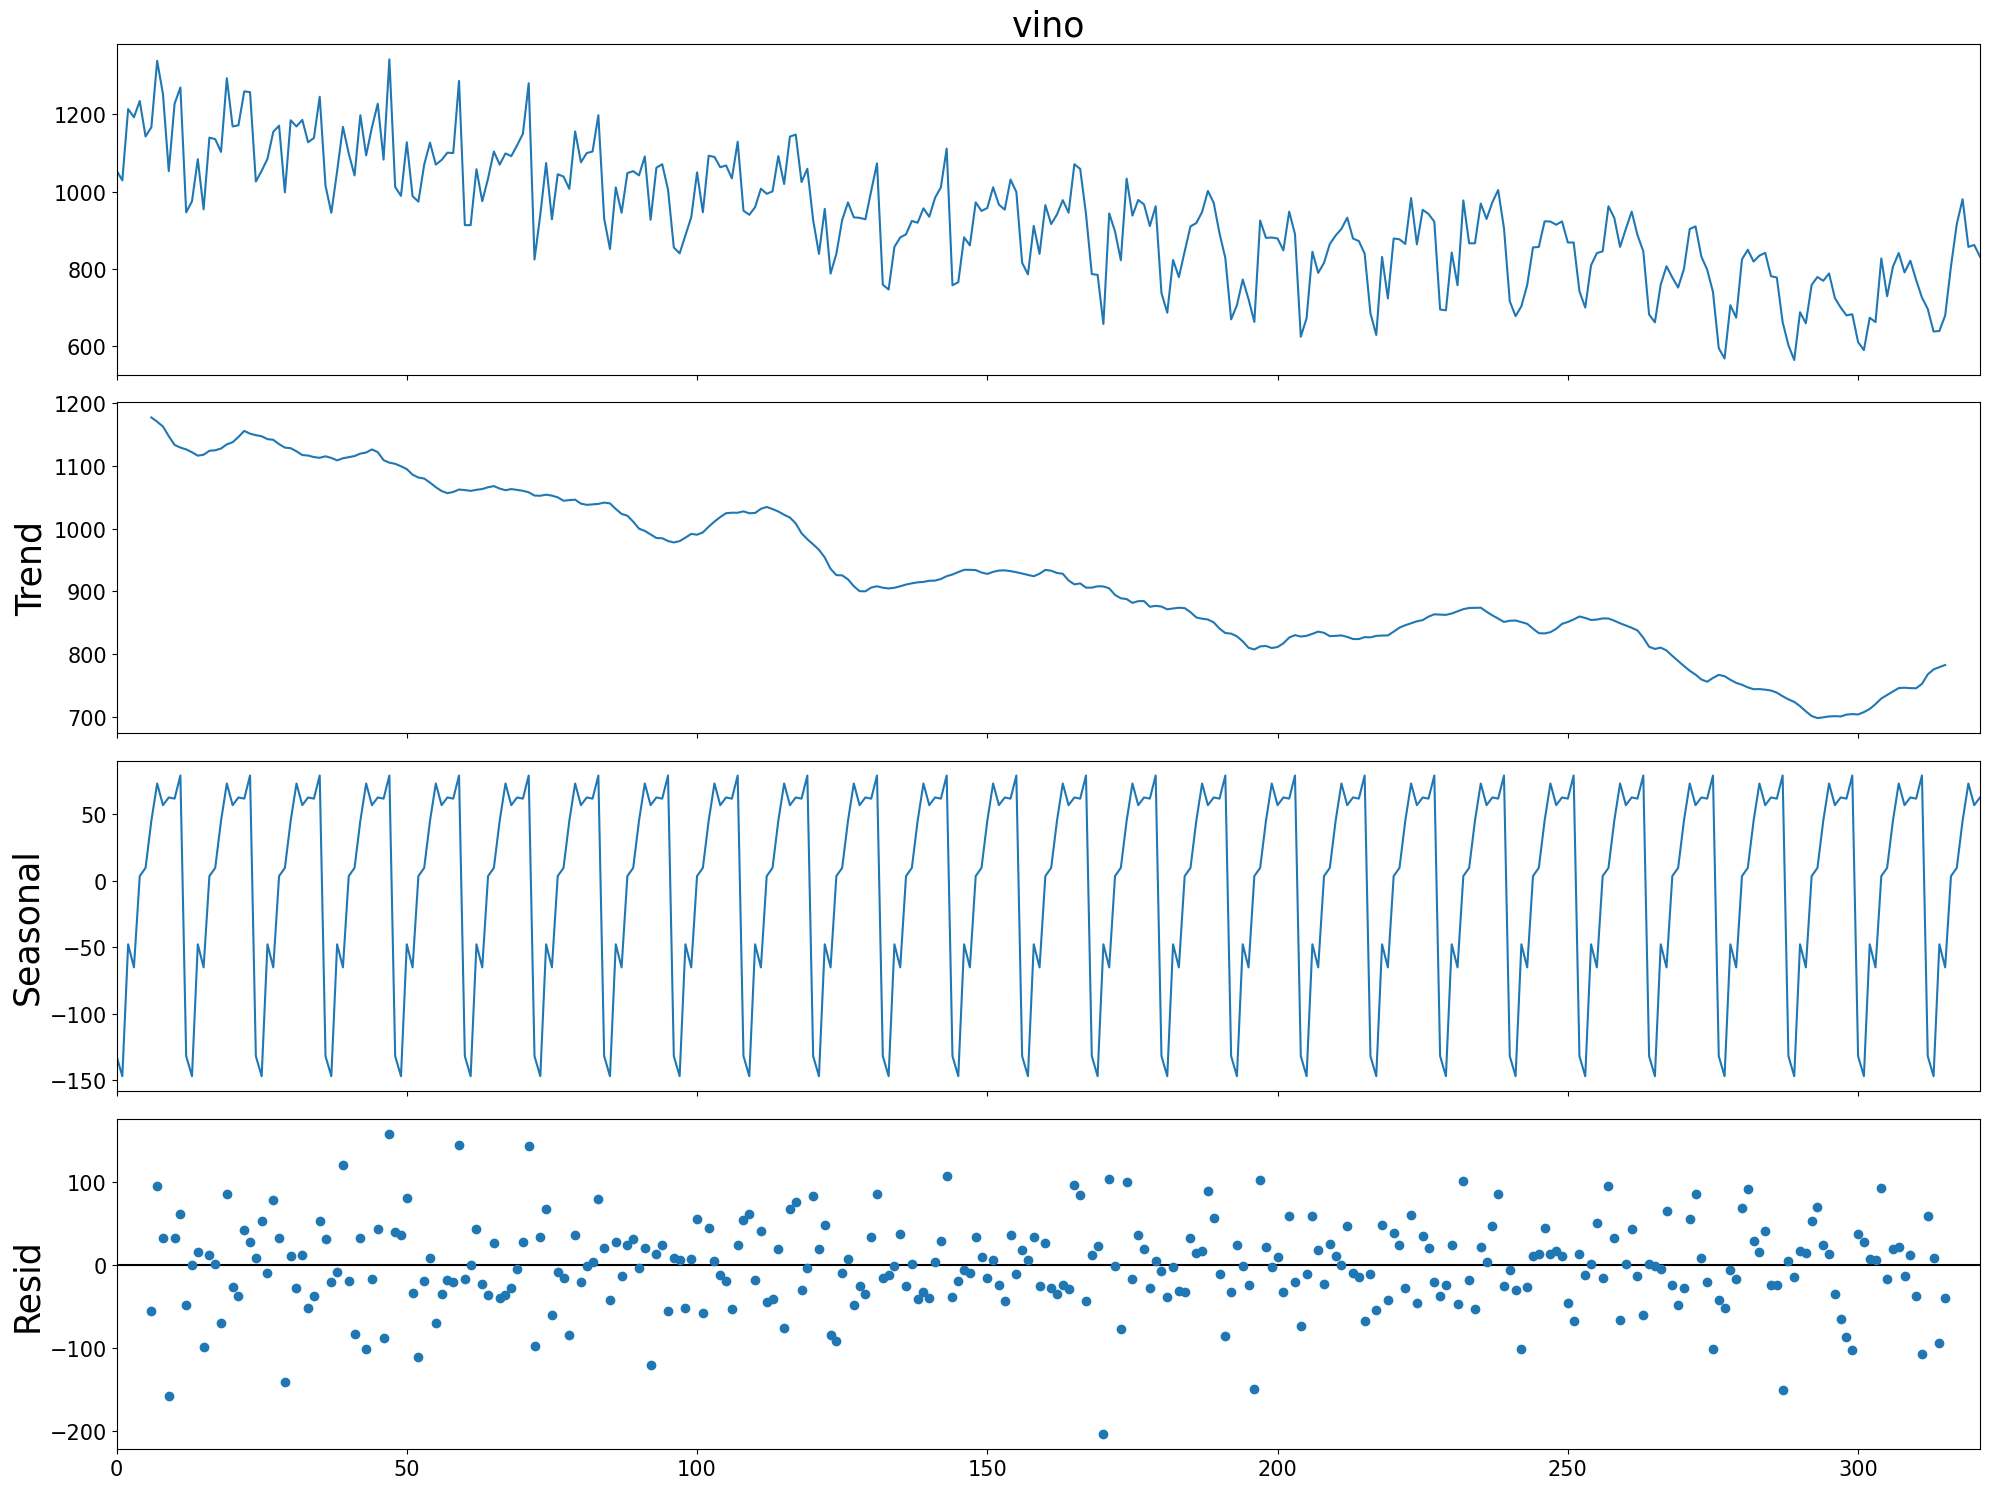

In [13]:
#Aditiva
params = {'axes.labelsize': 25,
              'axes.titlesize': 25,
              'figure.figsize': (20,15),
              'xtick.labelsize': 15,
              'ytick.labelsize': 15}
plt.rcParams.update(params)
decomposition_add = sm.tsa.seasonal_decompose(dataset['vino'], model='additive',period=12)

decomposition_add.plot()
plt.show()

## Preprocesamiento

Lo que se puede observar a simple viste es que la media no es constante y la covarianza podría ser constante.  
Se probara algunas transformaciones para poder quitar la tendencia decreciente buscando una media constante y poder evaluar la covarianza a tra vez de la correlación.

#### Diferenciación
Para eliminar la tendencia decreciente se realizará la trasformación de diferenciación:

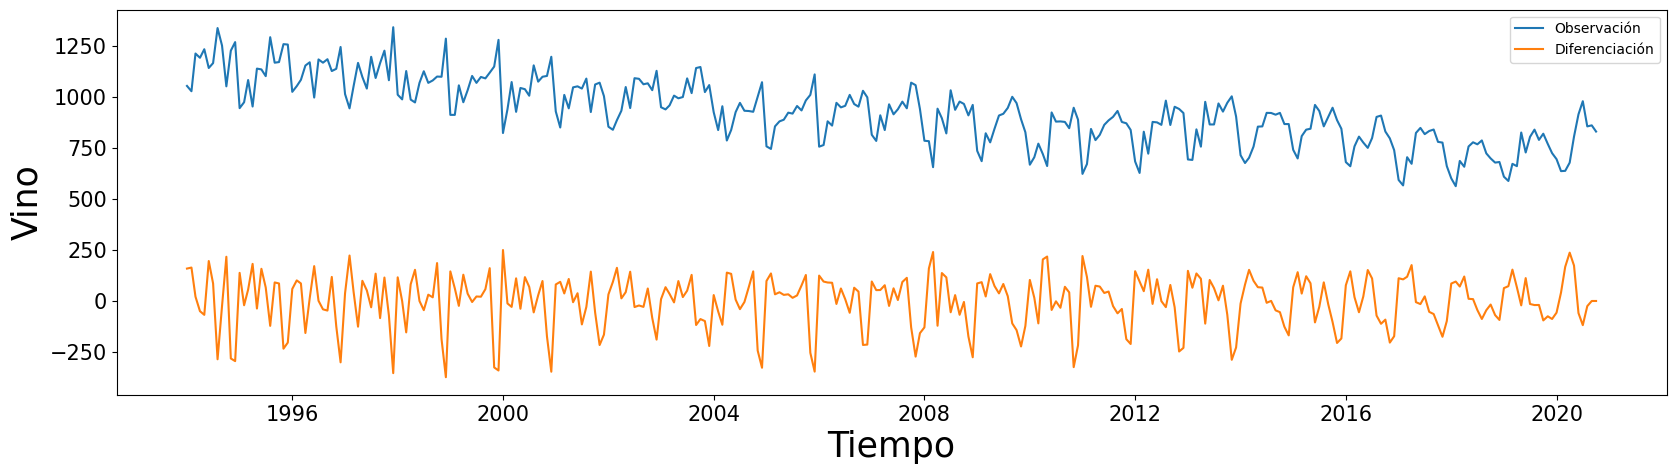

In [14]:
diff = list()
for i in range(2, len(dataset)):
	value = dataset['vino'][i] - dataset['vino'][i - 2]
	diff.append(value)
diff.append(0)
diff.append(0)

# GRAFICO
plt.figure(figsize=(20, 5))

# Serie original
plt.plot(dataset['indice_tiempo'], dataset['vino'], label='Observación')

# Serie diferenciada
plt.plot(dataset['indice_tiempo'], diff, label='Diferenciación')
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel("Vino")
plt.show()

Diferenciando la serie se pudo eliminar la tendencia decreciente y se puede asumir que la media es constante e igual a 0.  

Para testear la estacionareidad se puede ver como se comportan los coeficientes autocorrelación:

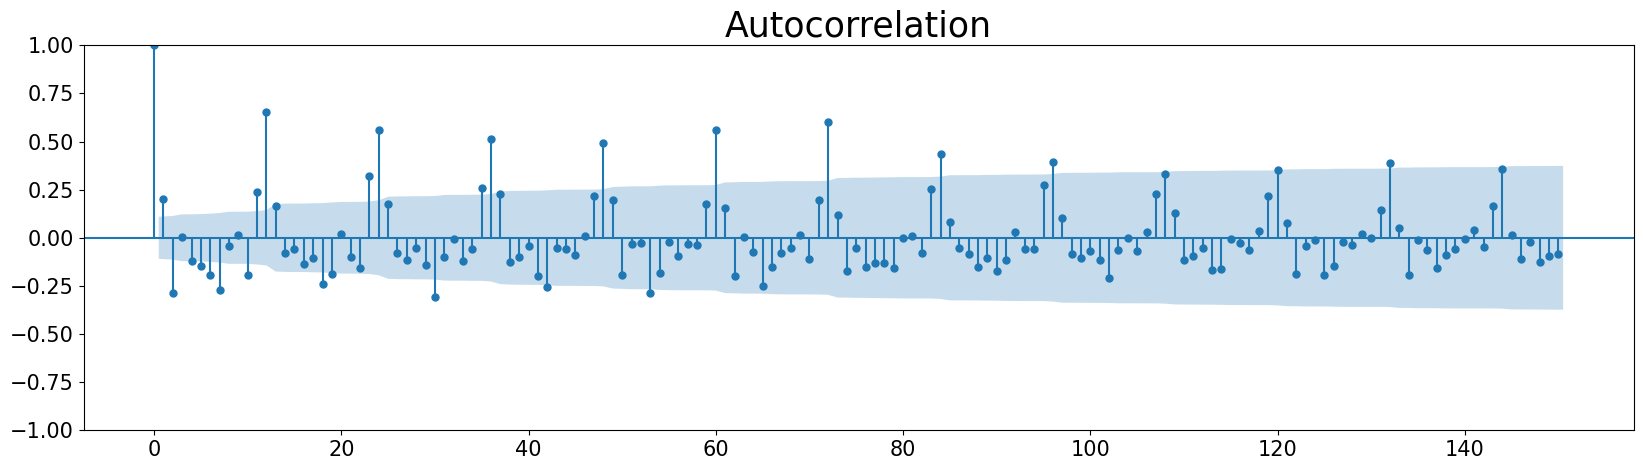

In [15]:
fig, ax = plt.subplots(figsize=(20,5))
plot_acf(diff, lags=150, ax=ax)
plt.show()

Se puede observar que no hay una caída de los valores de los coeficientes, esto nos indica que no es estacionaria.  

Por otro lado si bien la diferenciación quita la tendencia decreciente bastante bien, introduce un comportamiento que no es nativo de la serie original. En este caso que la tendencia parece bastante lineal es mejor opción encontrar el tendencia por cuadrados minimos y restarla a la serie.

### Tendencia determinística - Aproximación por cuadrados mínimos

In [16]:
# Transformo los datos de tipo DateTime a números flotantes, porque sino curve_fit no funciona.
ts = np.array([t.timestamp() for t in dataset.indice_tiempo])

##### Tendencia lineal

In [17]:
# Función objetivo.
def objective(x, a, b):
	return a * x + b

#Fiteo la curva.
parameters, covariance = curve_fit(objective, ts, dataset['vino'])

#Muestro los parámetros.
a, b = parameters
print ("Parámetros:",parameters)
print('Modelo: y = %.8f * x + %.8f' % (a, b))

Parámetros: [-5.1242089e-07  1.5318092e+03]
Modelo: y = -0.00000051 * x + 1531.80920199


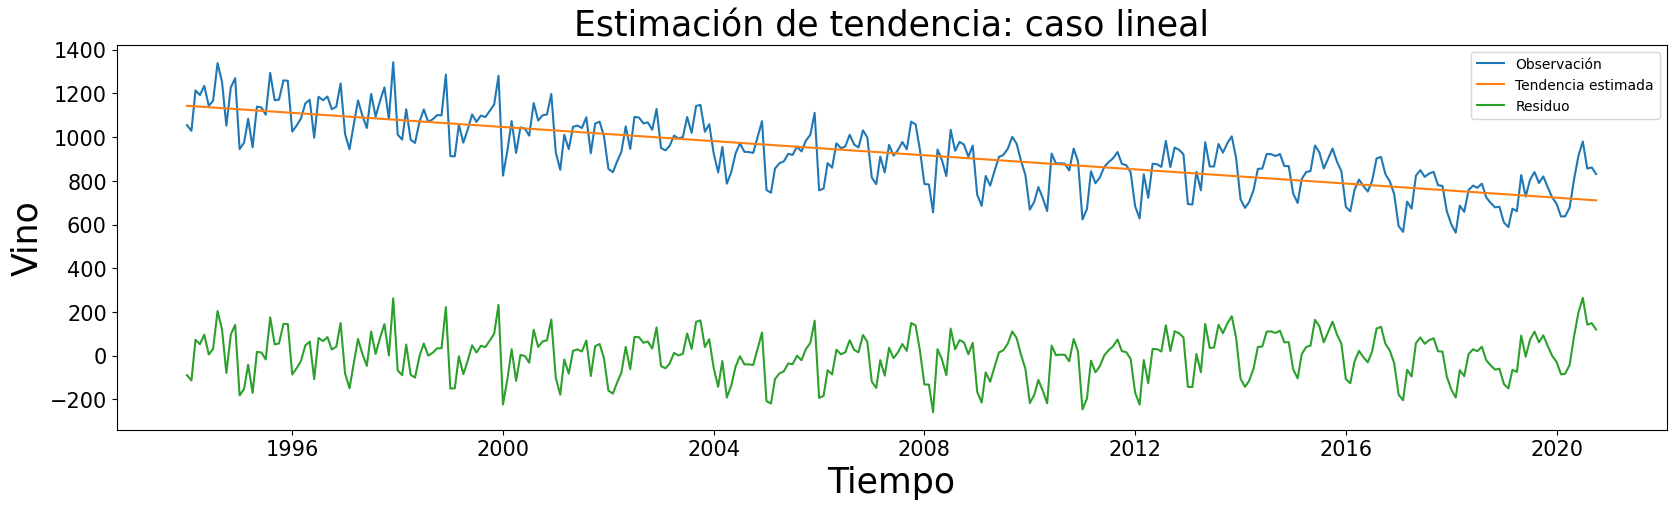

In [18]:
# GRAFICO
plt.figure(figsize=(20, 5))

# Serie original
plt.plot(dataset['indice_tiempo'], dataset['vino'], label='Observación')

# Estimación de la tendencia.
plt.plot(dataset['indice_tiempo'], objective(ts, *parameters), label='Tendencia estimada')

# Residuo. Original - Tendencia
residuo = dataset['vino'] - objective(ts, *parameters)
plt.plot(dataset['indice_tiempo'], residuo, label='Residuo')
plt.title("Estimación de tendencia: caso lineal")
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel("Vino")
plt.show()

### Tendencia cuadratica

In [19]:
# Función objetivo.
def objective(x, a, b, c):
	return a*x + b*x*x + c

#Fiteo la curva.
parameters, covariance = curve_fit(objective, ts, dataset['vino'])

#Muestro los parámetros.
a, b, c = parameters
print ("Parámetros:",parameters)
print('Modelo: y = %.8f * x + %.8f * x*x + %.8f' % (a, b, c))

Parámetros: [-1.19420380e-06  2.89040265e-16  1.91658194e+03]
Modelo: y = -0.00000119 * x + 0.00000000 * x*x + 1916.58193845


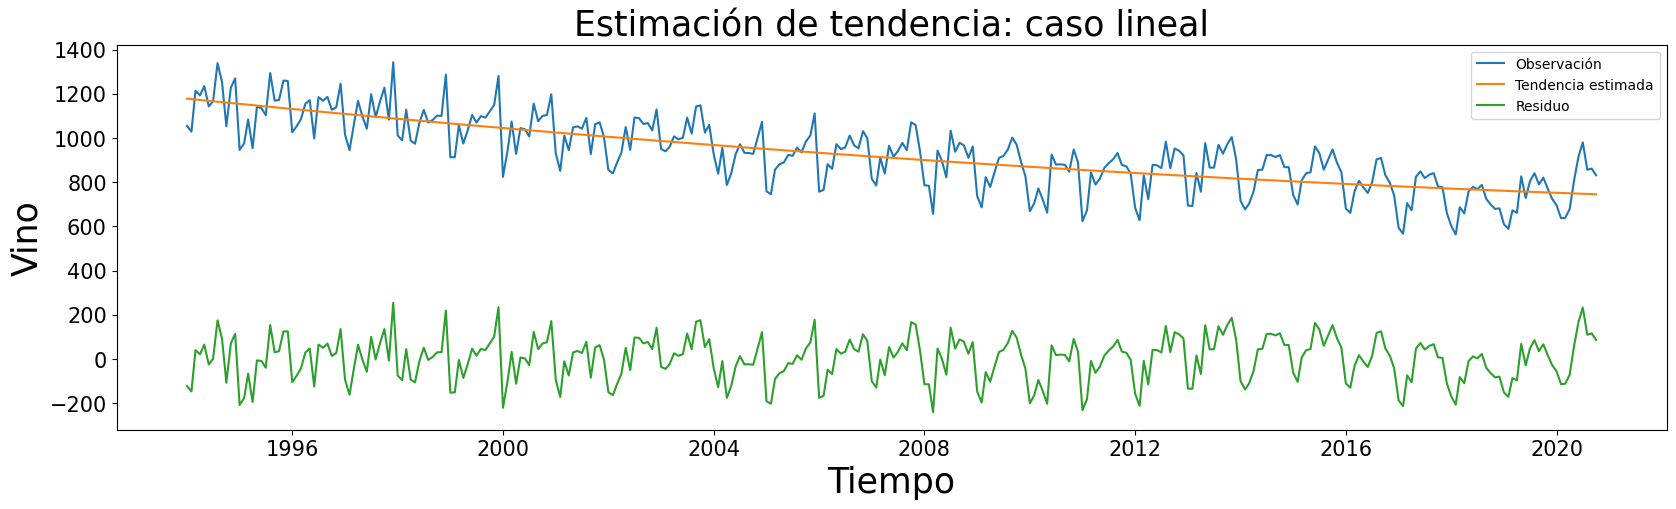

In [20]:
# GRAFICO
plt.figure(figsize=(20, 5))

# Serie original
plt.plot(dataset['indice_tiempo'], dataset['vino'], label='Observación')

# Estimación de la tendencia.
plt.plot(dataset['indice_tiempo'], objective(ts, *parameters), label='Tendencia estimada')

# Residuo. Original - Tendencia
residuo = dataset['vino'] - objective(ts, *parameters)
plt.plot(dataset['indice_tiempo'], residuo, label='Residuo')
plt.title("Estimación de tendencia: caso lineal")
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel("Vino")
plt.show()

No se observa demasiada diferencia respecto a la tendencia lineal

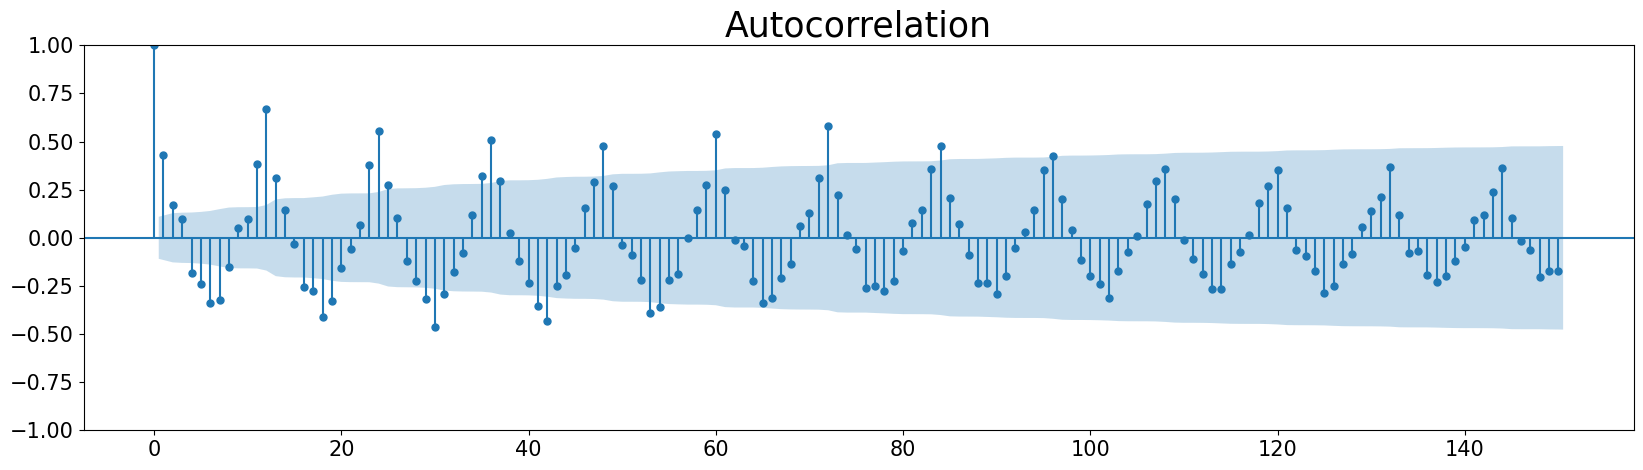

In [21]:
fig, ax = plt.subplots(figsize=(20,5))
plot_acf(residuo, lags=150, ax=ax)
plt.show()

No hay decrecimiento exponencial.  

Se infiere que aunque se suprima la tendencia lineal o cuadratica continúa siendo NO estacionaria.  

## Caso cíclico

In [22]:
# Período de 1 año, 12 muestras
period =12

# Cálculo de los parámetros de la observación por cuadrados mínimos.
# Utilizo el residuo anterior para eliminar la tendencia lineal

# Como el ultimo año no llega a los 12 meses, lo elimino para poder tomar ciclos completos
data = residuo[:len(residuo)-10]

rows = int(len(data)/period)
data = np.array(data).reshape(rows,period)
print ("Cantidad de períodos:",data.shape[0])
betas = data.mean(axis=0)
print ("Parámetros estimados (betas):\n",betas)

Cantidad de períodos: 26
Parámetros estimados (betas):
 [-136.10693451 -149.57678835  -43.39773796  -62.66779697    3.78557958
    5.98719639   43.14852816   71.39397196   54.92287448   60.31587281
   59.29246424   76.95771933]


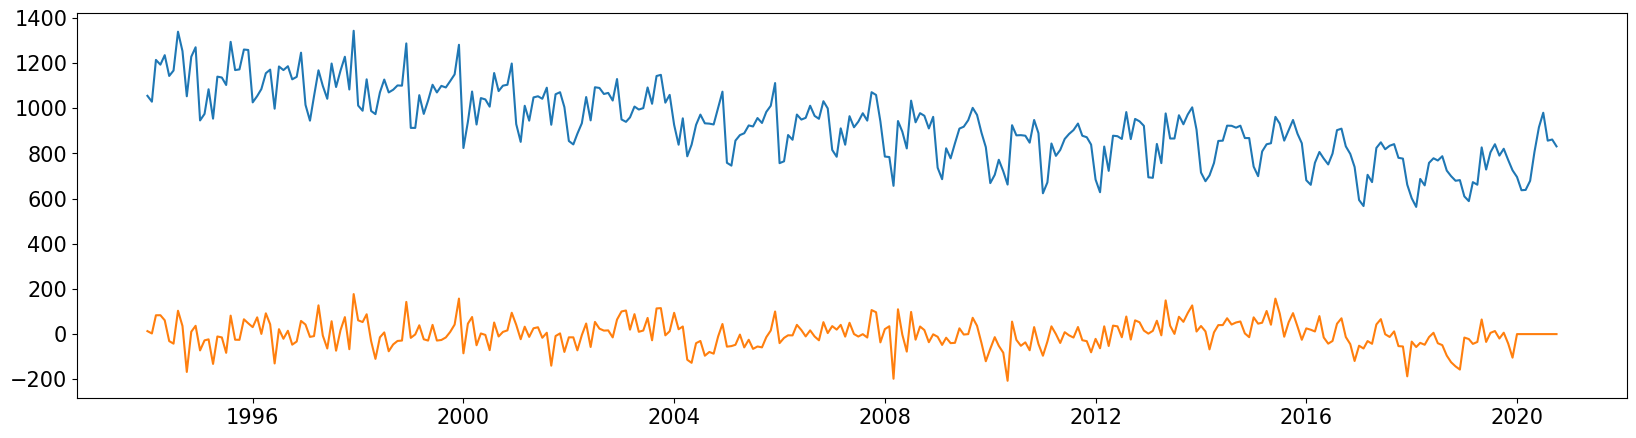

In [23]:
res_data = data - betas
res_data = res_data.reshape(-1)
res_data = np.concatenate((res_data, np.zeros(10)), axis=None)

plt.figure(figsize=(20, 5))
plt.plot(dataset['indice_tiempo'], dataset['vino'], label='Observación')
plt.plot(dataset['indice_tiempo'], res_data, label='Residuo')

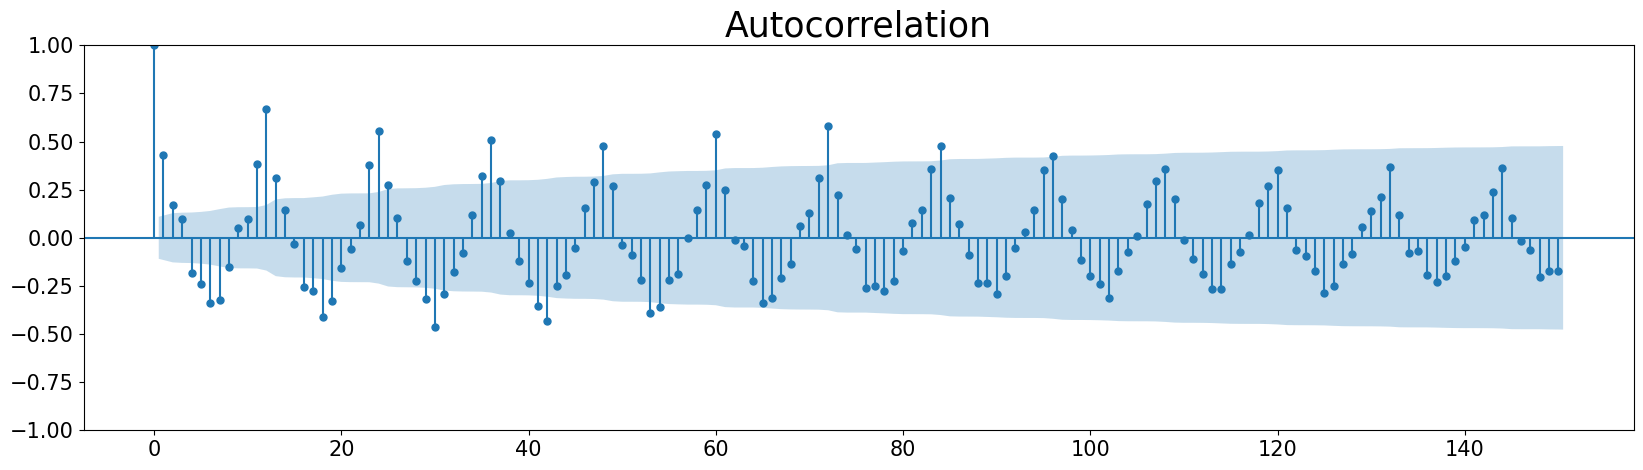

In [24]:
fig, ax = plt.subplots(figsize=(20,5))
plot_acf(residuo, lags=150, ax=ax)
plt.show()

Los coeficientes caen en la zona donde son considerados nulos pero aún no se puede determinar que la serie resultante sea estacionaria.

### Tests para determinar estacionariedad

Se va a trabajar con la serie a la cual se le elimina la tendecia lineal calculada por cuadrados mínimos.

#### Test de Dickey-Fuller

In [25]:
from statsmodels.tsa.stattools import adfuller, kpss
serie = residuo
time = dataset['indice_tiempo']


dftest = adfuller(serie)
dfoutput = pd.Series(
    dftest[0:4],
    index=["Estadístico",
        "p-valor",
        "# Lags usados",
        "# Observaciones usadas",
    ],
)
for key, value in dftest[4].items():
    dfoutput["Valor del umbral (%s)" % key] = value
print(dfoutput)

Estadístico                -4.318932
p-valor                     0.000412
# Lags usados              17.000000
# Observaciones usadas    304.000000
Valor del umbral (1%)      -3.452045
Valor del umbral (5%)      -2.871095
Valor del umbral (10%)     -2.571861
dtype: float64


El estadístico es menor que los 3 umbrales, por lo tanto puedo rechazar la hipótesis nula. Por otro lado, el p-valor es muy chico.  
Según este test la serie diferenciada es ESTACIONARIA.

#### Test KPSS

In [26]:
kpsstest = kpss(serie)
kpss_output = pd.Series(
    kpsstest[0:3], index=["Estadístico", "p-valor", "Lags usados"]
)
for key, value in kpsstest[3].items():
    kpss_output["Valor del umbrarl (%s)" % key] = value
print(kpss_output)

Estadístico                 0.040966
p-valor                     0.100000
Lags usados                 7.000000
Valor del umbrarl (10%)     0.347000
Valor del umbrarl (5%)      0.463000
Valor del umbrarl (2.5%)    0.574000
Valor del umbrarl (1%)      0.739000
dtype: float64


/tmp/ipykernel_8210/1597251960.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(serie)


En este caso el p-valor no es significantemente chico por lo que no puedo rechazar el test, puedo asumir entonces que la serie es ESTACIONARIA.

Ambos test dan indicio que la serie es ESTACIONARIA.

### Modelo ARIMA
Bajo la afirmación que {Yt} sigue un modelo ARIMA si  $W_t=\nabla^d Y_t$  es un proceso ARMA(p,q) estacionario, se testeará la serie para ver si es posible modelarla con este modelo.  

Calculo de la diferenciación:  

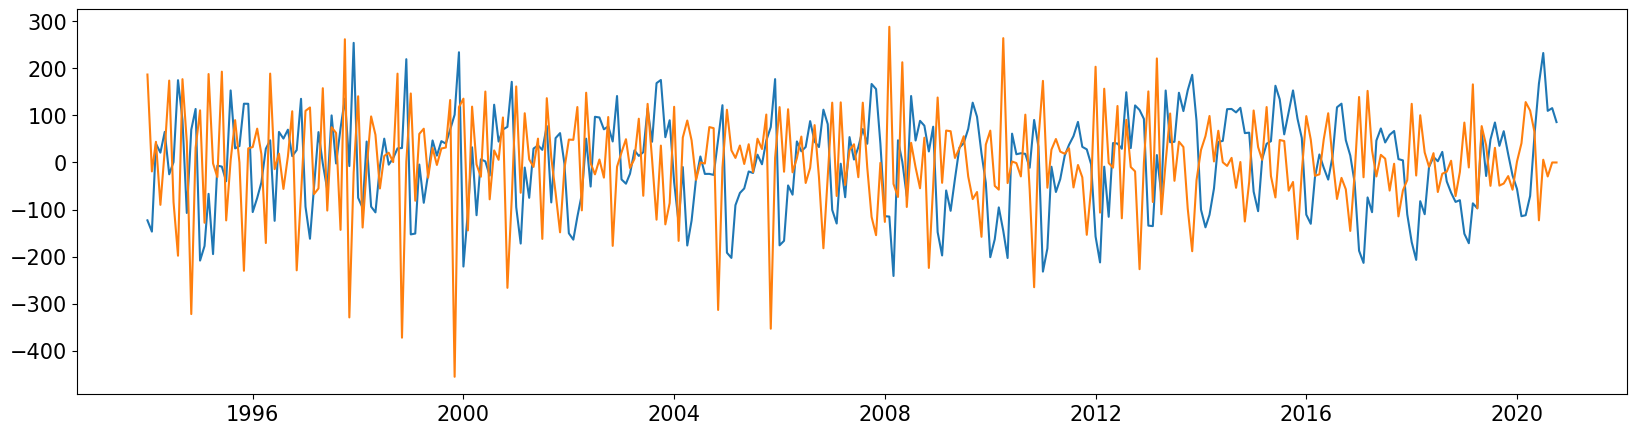

In [41]:
diff = list()
for i in range(2, len(serie)):
	value = serie[i] - serie[i - 1]
	diff.append(value)
diff.append(0)
diff.append(0)

plt.figure(figsize=(20, 5))
plt.plot(time, serie, label='Observación')
plt.plot(time, diff, label='Serie Diferenciada')

Calculo de la correlación y la correlación parcial:

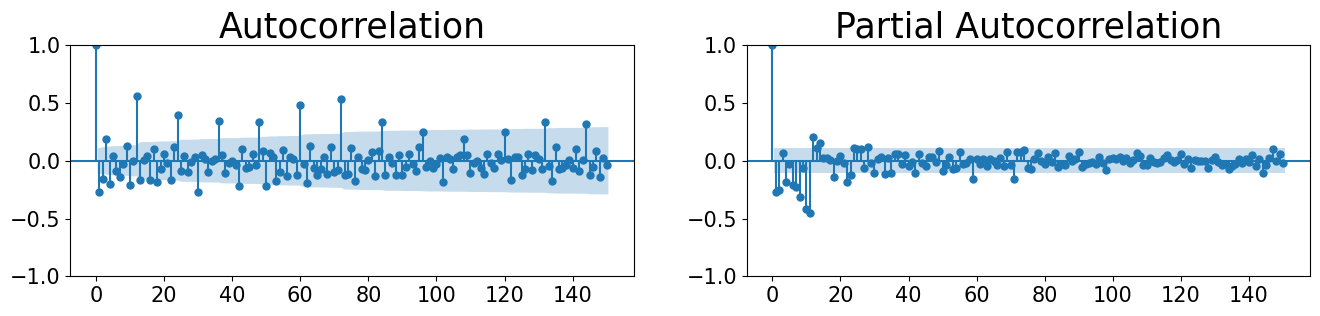

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(16,3))
a = plot_acf(np.array(diff), ax=ax[0], lags=150)
a = plot_pacf(np.array(diff), ax=ax[1], lags=150)

In [44]:
p = 12
q = 85
d = 1

model = ARIMA(serie, order=(p,d,q))
model_fit = model.fit()

print(model_fit.summary())


/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                   vino   No. Observations:                  322
Model:               ARIMA(12, 1, 85)   Log Likelihood               -1832.333
Date:                Wed, 17 Apr 2024   AIC                           3860.667
Time:                        00:04:52   BIC                           4230.268
Sample:                             0   HQIC                          4008.239
                                - 322                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3562     42.828     -0.008      0.993     -84.298      83.585
ar.L2         -0.0448     46.549     -0.001      0.999     -91.280      91.190
ar.L3         -0.2397     37.123     -0.006      0.9

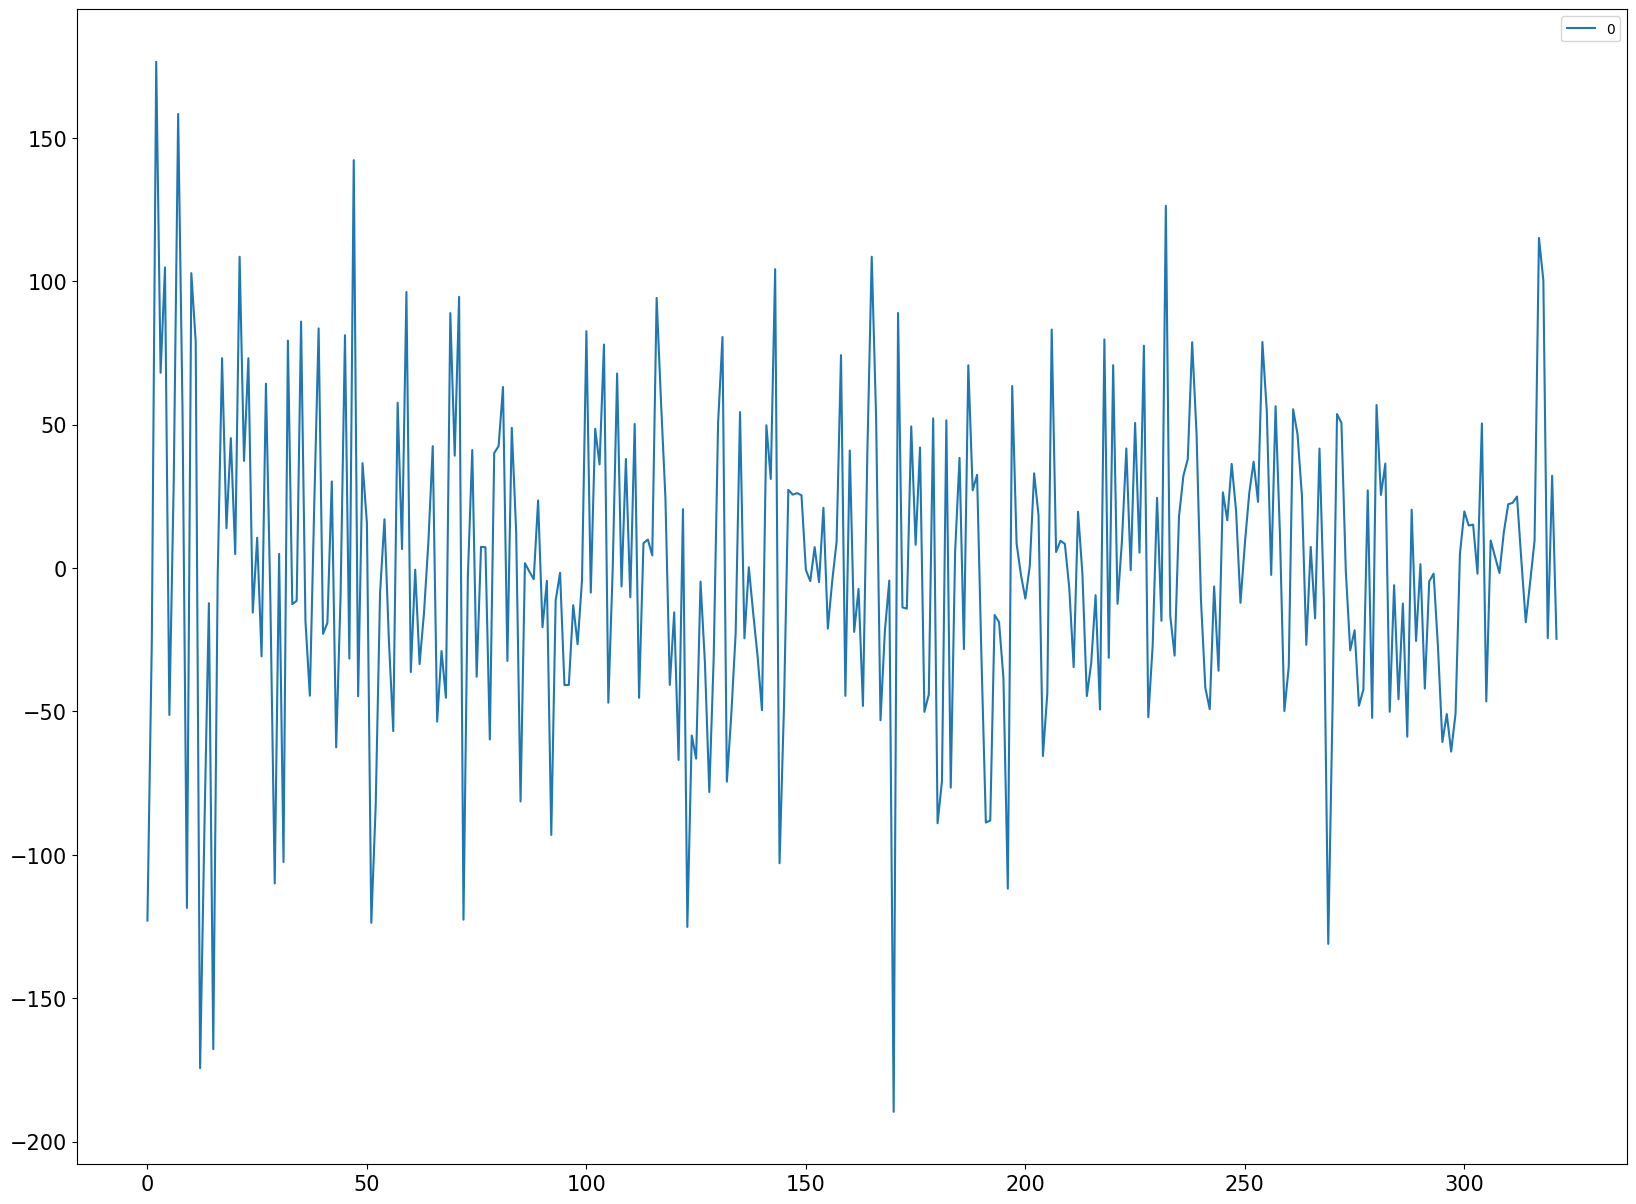

In [45]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()